<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Классические-модели-машинного-обучения" data-toc-modified-id="Классические-модели-машинного-обучения-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Классические модели машинного обучения</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Обучение-с-использованием-BERT" data-toc-modified-id="Обучение-с-использованием-BERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение с использованием BERT</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод по разделу</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 


**Цель:** 

- Обучить модель классифицировать комментарии на позитивные и негативные. 
- Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

В нашем распоряжении набор данных с разметкой о токсичности правок. Они находятся в файле `toxic_comments.csv`
 - *text* — текст комментария 
 - *toxic* — целевой признак

## Загрузка данных

In [7]:
!pip install transformers -q

In [8]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize  
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
import transformers
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
import torch.nn.utils as nn_utils
import warnings

In [10]:
pd.options.display.max_colwidth = 0
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /Users/kvl38/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kvl38/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kvl38/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/kvl38/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [11]:
# Задаем значения констант
RANDOM_STATE = 42
TEST_SIZE = 0.25
cv = 3

In [12]:
# Функция обработки комментария
def data_preparation(comment):
    
    """
    Очищает и подготавливает текст для анализа в задачах обработки естественного языка (NLP).
    Функция возвращает обработанный текст в виде строки.

    Parameters
    ----------
    comment : str
        Исходный текстовый комментарий на английском языке.

    Returns
    -------
    str
        Предобработанный текст, содержащий только значимые слова в начальной форме, разделённые пробелами.
    """
    
    comment = re.sub(r'[^a-zA-Z]', ' ', comment)
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    tags = nltk.pos_tag(tokens)
    lemmatized = [ lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tags ]
    comment = ' '.join(lemmatized)
    return comment

In [15]:
# Функция преобразования POS-тега
def get_wordnet_pos(tag):
    
    """
    Преобразует POS-тег из формата NLTK в формат, поддерживаемый WordNetLemmatizer.
    Функция использует первую букву POS-тега, чтобы определить соответствующую часть речи WordNet

    Parameters
    ----------
    tag : str
        POS-тег.

    Returns
    -------
    str
        Части речи в формате WordNet.
    """
    tag_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'J': wordnet.ADJ,
        'R': wordnet.ADV
    }
    
    return tag_map.get(tag[0], wordnet.NOUN)

In [16]:
# Загружаем данные
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
    bert_df = df.copy()
    
except Exception as e:
    print(f"Произошла ошибка: {e}")

# Выводим первые 5 строк загруженных данных
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [17]:
# Выводим основную информацию по загруженным данным
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [18]:
# Удаляем столбец 'Unnamed: 0'
del df['Unnamed: 0']

# Проверяем корректность преобразований
df.columns

Index(['text', 'toxic'], dtype='object')

In [19]:
# Выводим 3 токсичных комментария
df[df['toxic'] == 1].sample(3)

,text,toxic
121655,you are a fucking retard,1
46959,hey ricboom who ever the fuck you are if you go to my schoolim gonna beat the shit out of you,1
67825,wow its obvious koreans cannot make a single edit without cursing,1


In [20]:
# Найдем число полных дубликатов
df.duplicated().sum()

np.int64(0)

In [21]:
# Убедимся в отсутствии пропусков
df.isnull().sum()

text     0
toxic    0
dtype: int64

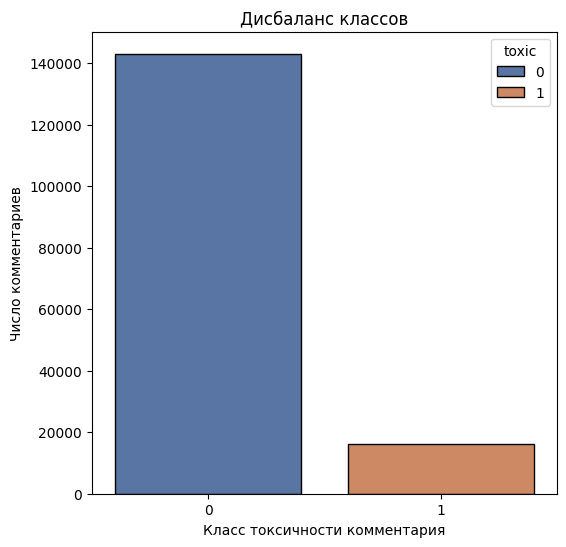

In [22]:
# Строим график распределения классов
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='toxic', hue='toxic', palette='deep', edgecolor='black')
plt.title('Дисбаланс классов')
plt.ylabel('Число комментариев')
plt.xlabel('Класс токсичности комментария')
plt.show()

**Вывод по разделу:**
- Датасет содержит информацию о 159292 комментариях и их принадлежности к классу токсичности (токсичный или нет)
- Токсичные комментарии обозначены меткой 1 в столбце toxic, нетоксичные — 0
- Наблюдается дисбаланс классов: нетоксичных комментариев примерно в 9 раз больше, чем токсичных. Это необходимо учитывать при обучении моделей классификации
- Все комментарии написаны на английском языке, поэтому требуется соответствующая языковая обработка
- Названия столбцов соответствуют принятым стандартам
- Типы данных соответствуют содержанию

## Классические модели машинного обучения

### Подготовка данных

In [27]:
# Получаем множество стоп-слов
nltk.download('stopwords')
stopwords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /Users/kvl38/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Создаем объект для приведения каждого слова к базовой форме
lemmatizer = WordNetLemmatizer()

In [29]:
# Выводим первые строки до преобразований
df.head(2)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0


In [30]:
# Приводим комментарии к правильному для обработки виду
df['proc_comment'] = df['text'].apply(data_preparation)

# Проверяем корректность преобразований
df.head(2)

,text,toxic,proc_comment
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he match this background colour i m seemingly stick with thanks talk january utc


In [31]:
# Разделяем исходные данные на обучающую и тестовую выборки с учетом дисбаланса классов
X = df['proc_comment']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)
# Рассмотрим размеры сформированных выборок
X_train.shape, X_test.shape

((119469,), (39823,))

In [32]:
# Векторизация текста с помощью TF-IDF
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test = count_tf_idf.transform(X_test)

### Обучение моделей

Подбираем гиперпараметры для каждой модели с помощью GridSearchCV и на кросс-валидации определяем параметры и метрику лучшей модели

In [48]:
# Создаём пайплайн
pipe = Pipeline([
    ('model', LogisticRegression())
])

param_grid = [
    {
        'model': [LogisticRegression(penalty='l2', max_iter=500)],
        'model__C': [2, 10]
    },

    {
        'model': [RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__max_depth': [10, 20]
    },

    {
        'model': [LGBMClassifier(learning_rate=0.1, force_row_wise=True, verbose=-1, random_state=RANDOM_STATE)],
        'model__max_depth': [10, 20]
    },

    {
        'model': [CatBoostClassifier(learning_rate=0.1, iterations=50, verbose=0, random_state=RANDOM_STATE)],
        'model__depth': [10, 20]
    }
]

In [49]:
# Найдем лучшую модель, используя метрику 'f1'
grid = GridSearchCV(pipe, 
                    param_grid, 
                    scoring='f1', 
                    cv=cv, 
                    n_jobs=1, 
                    verbose=0)

grid.fit(tf_idf_train, y_train)
print("Параметры лучшей модели:\n", grid.best_estimator_)

Параметры лучшей модели:
 Pipeline(steps=[('model', LogisticRegression(C=10, max_iter=500))])


In [50]:
# Выводим полученную метрику
print("Лучшая метрика F1 на обучении:", round(grid.best_score_, 3))

Лучшая метрика F1 на обучении: 0.763


По результатам кросс-валидации на обучающей выборке лучшее качество показала модель LogisticRegression с метрикой F1 = 0.763

### Вывод по разделу

На данном этапе были подготовлены данные для моделирования. Текст комментариев был предварительно обработан: удалены все символы, кроме букв, тексты приведены к нижнему регистру, очищены от стоп-слов и преобразованы в векторы признаков с использованием TF-IDF.
На полученных признаках были обучены четыре модели классификации: LogisticRegression, RandomForest, LightGBM и CatBoost.
На обучающей выборке лучший результат по метрике F1 показала модель LogisticRegression.

## Обучение с использованием BERT

### Подготовка данных

In [54]:
# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [55]:
# Случайно выбираем 30000 строк для ускорения обучения модели
bert_df = bert_df[['text', 'toxic']]
bert_df = bert_df.sample(n=60000, random_state=RANDOM_STATE)

In [56]:
# Рассмотрим распределение классов
bert_df['toxic'].value_counts()

toxic
0    53947
1    6053 
Name: count, dtype: int64

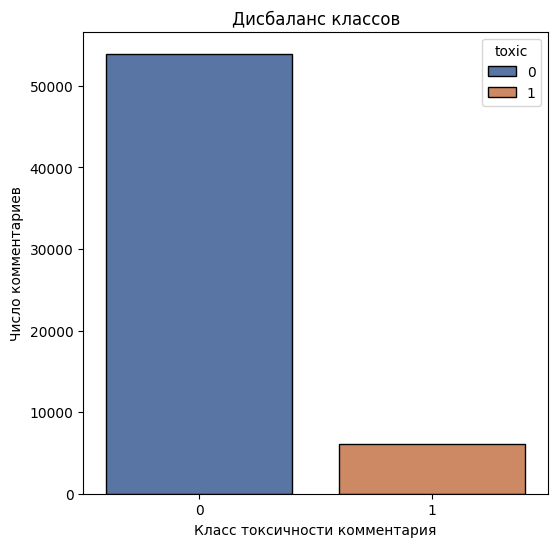

In [57]:
# Строим график распределения классов
plt.figure(figsize=(6, 6))
sns.countplot(data=bert_df, x='toxic', hue='toxic', palette='deep', edgecolor='black')
plt.title('Дисбаланс классов')
plt.ylabel('Число комментариев')
plt.xlabel('Класс токсичности комментария')
plt.show()

In [59]:
# Разделяем исходные данные на обучающую, валидационную и тестовую выборки с учетом дисбаланса классов
X = bert_df['text']
y = bert_df['toxic']

X_tmp, X_test, y_tmp, y_test = train_test_split(X.values, 
                                                y.values, 
                                                test_size=0.2, 
                                                random_state=RANDOM_STATE, 
                                                stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_tmp, 
                                                  y_tmp, 
                                                  test_size=0.25, 
                                                  random_state=RANDOM_STATE, 
                                                  stratify=y_tmp)

# Рассмотрим размеры сформированных выборок
X_train.shape, X_val.shape, X_test.shape

((36000,), (12000,), (12000,))

In [60]:
# Загружаем предобученный токенизатор и преобразуем тексты в формат, подходящий для модели
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=64, return_tensors='pt')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=64, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=64, return_tensors='pt')

In [61]:
# Формируем датасеты из закодированных входных данных и создаём DataLoader-ы для подачи данных в модель батчами
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

### Обучение модели

In [63]:
# Загружаем предобученную модель DistilBERT для бинарной классификации и инициализируем оптимизатор AdamW 
# для обновления параметров модели во время обучения
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, ignore_mismatched_sizes=True)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=0.01)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
# Переводим модель в режим обучения и проходим по данным несколько эпох,
# для каждого батча считаем предсказания, вычисляем функцию потерь (loss),
# делаем обратное распространение ошибки, обновляем веса и выводим F1-score на обучении и валидации по каждой эпохе
model.train()
for epoch in range(2):
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        nn_utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(all_labels, all_preds)

    # Валидация
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds)
    print(f"Epoch {epoch+1} | Train F1: {round(train_f1, 3)} | Val F1: {round(val_f1, 3)}")
    model.train()

Epoch 1: 100%|██████████████████████████████| 2250/2250 [12:08<00:00,  3.09it/s]


Epoch 1 | Train F1: 0.758 | Val F1: 0.776


Epoch 2: 100%|██████████████████████████████| 2250/2250 [12:11<00:00,  3.08it/s]


Epoch 2 | Train F1: 0.872 | Val F1: 0.816


### Вывод по разделу

На данном этапе была сформирована выборка объёмом 60000 записей из общей совокупности данных — для удобства и эффективности обучения модели DistilBertForSequenceClassification. Тексты были обработаны с использованием предобученного токенизатора DistilBertTokenizer.
Обучение модели проводилось в течение двух эпох, поскольку уже на этом этапе она продемонстрировала результат, удовлетворяющий условиям задачи.

## Тестирование

Лучший результат на обучающей выборке показала модель DistilBertForSequenceClassification — её и будем использовать на тестовой выборке

In [73]:
# Переводим модель в режим оценки, проходим по тестовым данным без вычисления градиентов,
# получаем предсказания и собираем метки и прогнозы для последующего расчёта метрик
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

In [74]:
# Получаем метрику F1 модели
f1 = f1_score(test_labels, test_preds)
print(f'F1-score на тестовой выборке: {round(f1, 3)}')

F1-score на тестовой выборке: 0.812


**Вывод по разделу:**
На тестовых данных модель DistilBertForSequenceClassification продемонстрировала результат, соответствующий требованиям задачи. Значения метрик близки к результатам на тренировочной выборке, что указывает на отсутствие переобучения модели.

## Общий вывод

В данном исследовании рассмотрены 159292 комментария с указанием их принадлежности к классу токсичности (токсичный или нет). При этом количество нетоксичных комментариев примерно в 9 раз превышает количество токсичных, что могло повлиять на ход исследования.

Для моделей LogisticRegression, RandomForest, LightGBM и CatBoost текст комментариев был предварительно обработан: удалены все символы, кроме букв, приведён к нижнему регистру, очищен от стоп-слов и преобразован в вектор признаков с помощью TF-IDF. После подбора гиперпараметров и обучения моделей с использованием кросс-валидации лучшим результатом стала LogisticRegression с f1_score = 0.799.

Для модели DistilBertForSequenceClassification исходный датасет был сокращён до 60000 записей, а тексты обработаны с помощью предобученного токенизатора DistilBertTokenizer. Обучение модели велось в течение двух эпох, что уже позволило достичь метрики f1_score = 0.816.

На тестовых данных DistilBertForSequenceClassification показала f1_score = 0.812, что соответствует требованиям задачи.